In [7]:
from datetime import datetime
from time import sleep
import requests
import numpy as np

In [8]:
def t2s(the_time):
    return datetime.fromtimestamp(int(the_time)).strftime('%Y/%m/%d %H:%M')

# MySQL のデータを確認

In [11]:
import mysql.connector

cnt = mysql.connector.connect(
    host='localhost',
    port='3306',
    db='bitmex',
    user='bitmex',
    password='bitmex',
    charset='utf8'
)

cur = cnt.cursor()

In [12]:
sql = "select t from xbtusd_1m order by t asc"
cur.execute(sql)
data = cur.fetchall()

In [13]:
last_bar = None
for bar in data:
    if int(bar[0]) % (60*60*24) == 0: # 0:00
        day_frame = t2s(int(bar[0]))
    if last_bar == None:
        continue
    if int(bar[0])-int(last_bar[0]) != 60:
        print( "Error in the day of {}".format(day_frame))


## 最後のデータの確認

In [14]:
sql = "select * from xbtusd_1m order by t desc limit 1"
cur.execute(sql)
data = cur.fetchall()
db_last_t = data[0][0]
print(t2s(db_last_t), data[0])

2018/05/28 07:58 (1527461880, 7342.5, 7343.0, 7342.0, 7343.0, 123833)


## 最後のデータから現在までのデータを取得

In [15]:
data = []
num = 1440 - 1 # 60*24 - 1

last_time = int(datetime.now().strftime('%s'))
start_time = int(db_last_t) + 1

print("Current Time: ", t2s(last_time))

for frame_stime in range(start_time, last_time, 60*60*24):
    frame_etime = frame_stime + 60*num
    if frame_etime > last_time:
        frame_etime = last_time - 60*2 # for safety
    print( "Fetching data for {} - {}".format(t2s(frame_stime), t2s(frame_etime)) )

    com = "https://www.bitmex.com/api/udf/history?symbol=XBTUSD&resolution=1&from={0:}&to={1:}".format(frame_stime, frame_etime)
    ret = requests.get(com)
    
    d = ret.json()
    if d['s'] != 'ok':
        print("Failed for the time frame ({} - {})".format(frame_stime, frame_etime))
    dd = list(zip(d['t'], d['o'], d['h'], d['l'], d['c'], d['v']))
    data.extend(dd)
    
    sleep(5)

Current Time:  2018/05/29 18:15
Fetching data for 2018/05/28 07:58 - 2018/05/29 07:57
Fetching data for 2018/05/29 07:58 - 2018/05/29 18:13


In [16]:
data

[(1527461880, 7342.5, 7343, 7342, 7343, 123833),
 (1527461940, 7343, 7344, 7342.5, 7344, 329926),
 (1527462000, 7344, 7385, 7343.5, 7380, 7220689),
 (1527462060, 7380, 7382.5, 7360, 7368, 4140067),
 (1527462120, 7368, 7368, 7346.5, 7355.5, 4313361),
 (1527462180, 7355.5, 7355.5, 7349.5, 7350, 1674681),
 (1527462240, 7350, 7351.5, 7346.5, 7346.5, 2033417),
 (1527462300, 7346.5, 7346.5, 7332.5, 7337.5, 2618401),
 (1527462360, 7337.5, 7339.5, 7337, 7339.5, 722185),
 (1527462420, 7339.5, 7339.5, 7339, 7339.5, 304237),
 (1527462480, 7339.5, 7339.5, 7339, 7339.5, 64494),
 (1527462540, 7339.5, 7340, 7339, 7340, 260622),
 (1527462600, 7340, 7340, 7337.5, 7337.5, 1128214),
 (1527462660, 7337.5, 7338, 7333, 7333, 1032257),
 (1527462720, 7333, 7333.5, 7330.5, 7330.5, 1161980),
 (1527462780, 7330.5, 7331, 7330.5, 7331, 466036),
 (1527462840, 7331, 7331, 7326, 7326.5, 1681354),
 (1527462900, 7326.5, 7328.5, 7326, 7328.5, 637940),
 (1527462960, 7328.5, 7328.5, 7327.5, 7328, 1464039),
 (1527463020, 7

## 取得したデータをDBに追加

### 重複しているデータをDBから削除

In [17]:
start_time = data[0][0]
sql = 'delete from xbtusd_1m where t >= {}'.format(start_time)
cur.execute(sql)
cnt.commit()

### 取得したデータをDBに追加

In [18]:
sql = 'insert into xbtusd_1m values (%s, %s, %s, %s, %s, %s)'
cur.executemany(sql, data)
cnt.commit()

# データの確認

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
sql = "select t,c from xbtusd_1m where t >= {}".format(data[0][0])
cur.execute(sql)
ret = cur.fetchall()

In [21]:
data

[(1527461880, 7342.5, 7343, 7342, 7343, 123833),
 (1527461940, 7343, 7344, 7342.5, 7344, 329926),
 (1527462000, 7344, 7385, 7343.5, 7380, 7220689),
 (1527462060, 7380, 7382.5, 7360, 7368, 4140067),
 (1527462120, 7368, 7368, 7346.5, 7355.5, 4313361),
 (1527462180, 7355.5, 7355.5, 7349.5, 7350, 1674681),
 (1527462240, 7350, 7351.5, 7346.5, 7346.5, 2033417),
 (1527462300, 7346.5, 7346.5, 7332.5, 7337.5, 2618401),
 (1527462360, 7337.5, 7339.5, 7337, 7339.5, 722185),
 (1527462420, 7339.5, 7339.5, 7339, 7339.5, 304237),
 (1527462480, 7339.5, 7339.5, 7339, 7339.5, 64494),
 (1527462540, 7339.5, 7340, 7339, 7340, 260622),
 (1527462600, 7340, 7340, 7337.5, 7337.5, 1128214),
 (1527462660, 7337.5, 7338, 7333, 7333, 1032257),
 (1527462720, 7333, 7333.5, 7330.5, 7330.5, 1161980),
 (1527462780, 7330.5, 7331, 7330.5, 7331, 466036),
 (1527462840, 7331, 7331, 7326, 7326.5, 1681354),
 (1527462900, 7326.5, 7328.5, 7326, 7328.5, 637940),
 (1527462960, 7328.5, 7328.5, 7327.5, 7328, 1464039),
 (1527463020, 7

In [22]:
t = list(zip(*ret))

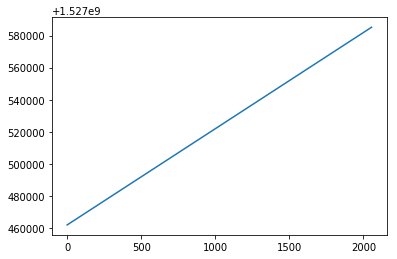

In [23]:
plt.plot(t[0])

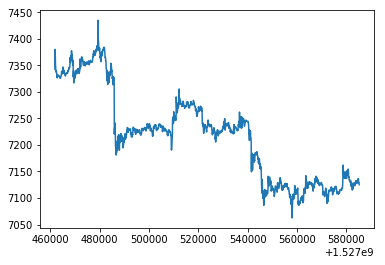

In [24]:
plt.plot(t[0],t[1])